In [1]:
ccard = spark.read.csv("s3://creditcard-smote/creditcard.csv",header = 'True',inferSchema='True')

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1575128975166_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
start_time = time.time()

ccard.printSchema()

print("--- %s seconds ---" % (time.time() - start_time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- Time: decimal(10,0) (nullable = true)
 |-- V1: double (nullable = true)
 |-- V2: double (nullable = true)
 |-- V3: double (nullable = true)
 |-- V4: double (nullable = true)
 |-- V5: double (nullable = true)
 |-- V6: double (nullable = true)
 |-- V7: double (nullable = true)
 |-- V8: double (nullable = true)
 |-- V9: double (nullable = true)
 |-- V10: double (nullable = true)
 |-- V11: double (nullable = true)
 |-- V12: double (nullable = true)
 |-- V13: double (nullable = true)
 |-- V14: double (nullable = true)
 |-- V15: double (nullable = true)
 |-- V16: double (nullable = true)
 |-- V17: double (nullable = true)
 |-- V18: double (nullable = true)
 |-- V19: double (nullable = true)
 |-- V20: double (nullable = true)
 |-- V21: double (nullable = true)
 |-- V22: double (nullable = true)
 |-- V23: double (nullable = true)
 |-- V24: double (nullable = true)
 |-- V25: double (nullable = true)
 |-- V26: double (nullable = true)
 |-- V27: double (nullable = true)
 |-- V28: double

In [5]:
#Extract 10% of the raw data for streaming purpose 
start_time = time.time()

(NonStreamData, StreamData) = ccard.randomSplit([0.9, 0.1],seed = 11)

print("--- %s seconds ---" % (time.time() - start_time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--- 0.0309293270111084 seconds ---

In [165]:
StreamData.coalesce(1).write.csv('s3://creditcard-smote/streamData.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer
import time
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
#Defining the function to vectorize a dataset and a function to do SmoteSampliing, source: https://github.com/Angkirat/Smote-for-Spark 

import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler

def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver//100
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = sc.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)//float(100)))
    return new_data_major.unionAll(new_data_minor)



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
#To vectorize the ccard dataset: 

ccard_vectorized = vectorizerFunction(ccard,'Class')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
ccard_vectorized.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
|[2.0,-0.425965884...|    0|
|[4.0,1.2296576345...|    0|
|[7.0,-0.644269442...|    0|
|[7.0,-0.894286082...|    0|
|[9.0,-0.338261752...|    0|
|[10.0,1.449043781...|    0|
|[10.0,0.384978215...|    0|
|[10.0,1.249998742...|    0|
|[11.0,1.069373587...|    0|
|[12.0,-2.79185476...|    0|
|[12.0,-0.75241704...|    0|
|[12.0,1.103215435...|    0|
|[13.0,-0.43690507...|    0|
|[14.0,-5.40125766...|    0|
|[15.0,1.492935976...|    0|
+--------------------+-----+
only showing top 20 rows

In [10]:
ccard.groupBy("Class").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------+
|Class| count|
+-----+------+
|    1|   492|
|    0|284315|
+-----+------+

From the result, we can tell that the Fraud transaction accounts only for 0.173% of the overall transaction, so we want to use SMOTE to upsample the fraud transactions to make it more balanced. 

In [8]:
a = SmoteSampling(ccard_vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 1900, percentageUnder = 5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
a.groupBy("label").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1| 9840|
+-----+-----+

In [13]:
a.show() 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[406.0,-2.3122265...|    1|
|[472.0,-3.0435406...|    1|
|[4462.0,-2.303349...|    1|
|[6986.0,-4.397974...|    1|
|[7519.0,1.2342350...|    1|
|[7526.0,0.0084303...|    1|
|[7535.0,0.0267792...|    1|
|[7543.0,0.3295943...|    1|
|[7551.0,0.3164590...|    1|
|[7610.0,0.7256457...|    1|
|[7672.0,0.7027099...|    1|
|[7740.0,1.0238738...|    1|
|[7891.0,-1.585505...|    1|
|[8090.0,-1.783228...|    1|
|[8169.0,0.8573210...|    1|
|[8408.0,-1.813280...|    1|
|[8415.0,-0.251470...|    1|
|[8451.0,0.3145965...|    1|
|[8528.0,0.4473955...|    1|
|[8614.0,-2.169928...|    1|
+--------------------+-----+
only showing top 20 rows

In [14]:
ccard_vectorized.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.0,-1.359807133...|    0|
|[0.0,1.1918571113...|    0|
|[1.0,-1.358354061...|    0|
|[1.0,-0.966271711...|    0|
|[2.0,-1.158233093...|    0|
|[2.0,-0.425965884...|    0|
|[4.0,1.2296576345...|    0|
|[7.0,-0.644269442...|    0|
|[7.0,-0.894286082...|    0|
|[9.0,-0.338261752...|    0|
|[10.0,1.449043781...|    0|
|[10.0,0.384978215...|    0|
|[10.0,1.249998742...|    0|
|[11.0,1.069373587...|    0|
|[12.0,-2.79185476...|    0|
|[12.0,-0.75241704...|    0|
|[12.0,1.103215435...|    0|
|[13.0,-0.43690507...|    0|
|[14.0,-5.40125766...|    0|
|[15.0,1.492935976...|    0|
+--------------------+-----+
only showing top 20 rows

In [9]:
#Combining the original vectorized dataset with the up-samples 

Combined = ccard_vectorized.union(a)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
Combined.groupBy("label").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------+
|label| count|
+-----+------+
|    0|284315|
|    1| 10332|
+-----+------+

Now, we have a more balanced dataset, the fraud to normal transaction ratio is about 28:1

In [11]:
#Split between the training data and test data:

(trainingData, testData) = Combined.randomSplit([0.8, 0.2],seed = 11)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
trainingData.groupBy("label").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+------+
|label| count|
+-----+------+
|    0|227477|
|    1|  8324|
+-----+------+

In [13]:
testData.groupBy("label").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    0|56838|
|    1| 2008|
+-----+-----+

In [15]:
# Train a logistic regression model
start_time = time.time()

lr = LogisticRegression(labelCol="label", featuresCol="features")
#Training algorithm
lrModel = lr.fit(trainingData)

print("--- %s seconds ---" % (time.time() - start_time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--- 19.405826568603516 seconds ---

In [16]:
# Train a Random Forest model
start_time = time.time()

rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rf_model = rf.fit(trainingData)

print("--- %s seconds ---" % (time.time() - start_time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--- 40.363991260528564 seconds ---

In [17]:
# Train a GBT model
start_time = time.time()

gbt = GBTClassifier(labelCol="label", featuresCol="features",maxIter=10)
gbt_model = gbt.fit(trainingData)

print("--- %s seconds ---" % (time.time() - start_time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

--- 32.99486780166626 seconds ---

In [ ]:
# Train a SVM model
start_time = time.time()


svm = LinearSVC(labelCol="label", featuresCol="features")
svm_model = svm.fit(trainingData)

print("--- %s seconds ---" % (time.time() - start_time))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
#Making prediction on training data

lr_prediction = lrModel.transform(trainingData)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
lr_prediction.select("prediction", "label", "features").show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|    0|[0.0,-1.359807133...|
|       0.0|    0|[0.0,1.1918571113...|
|       0.0|    0|[1.0,-1.358354061...|
|       0.0|    0|[2.0,-1.158233093...|
|       0.0|    0|[2.0,-0.425965884...|
+----------+-----+--------------------+
only showing top 5 rows

In [39]:
f1evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
accuracyevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
lr_accuracy = accuracyevaluator.evaluate(lr_prediction)
lr_f1 = f1evaluator.evaluate(lr_prediction) 
print("Accuracy of LogisticRegression is = %g"% (lr_accuracy))
print("F1 of LogisticRegression = %g " % (lr_f1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy of LogisticRegression is = 0.996643
F1 of LogisticRegression = 0.996586

In [44]:
#Making prediction on testdata from the random forest model

rf_test_prediction = rf_model.transform(testData)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
rf_accuracy = accuracyevaluator.evaluate(rf_test_prediction)
rf_f1 = f1evaluator.evaluate(rf_test_prediction) 
print("Accuracy of Random Forest on Test Data is = %g"% (rf_accuracy))
print("F1 of Random Forest on Test Data = %g " % (rf_f1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy of Random Forest on Test Data is = 0.995883
F1 of Random Forest on Test Data = 0.995588

In [46]:
#Making prediction on testdata from the GBT model

gbt_test_prediction = gbt_model.transform(testData)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
gbt_accuracy = accuracyevaluator.evaluate(gbt_test_prediction)
gbt_f1 = f1evaluator.evaluate(gbt_test_prediction) 
print("Accuracy of GBT on Test Data is = %g"% (gbt_accuracy))
print("F1 of GBT on Test Data = %g " % (gbt_f1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy of GBT on Test Data is = 0.996782
F1 of GBT on Test Data = 0.996741

In [49]:
svm_test_prediction = svm_model.transform(testData)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
svm_accuracy = accuracyevaluator.evaluate(svm_test_prediction)
svm_f1 = f1evaluator.evaluate(svm_test_prediction) 
print("Accuracy of SVM on Test Data is = %g"% (svm_accuracy))
print("F1 of SVM on Test Data = %g " % (svm_f1))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Accuracy of SVM on Test Data is = 0.996275
F1 of SVM on Test Data = 0.996206

In [43]:
lr_test_prediction.groupBy("label").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    0|56898|
|    1| 2139|
+-----+-----+

In [112]:
#Now, export the test data to local, and start the streaming process, refer to codes in another notebook "Stream" 

testData.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.0,-0.966271711...|    0|
|[9.0,-0.338261752...|    0|
|[10.0,0.384978215...|    0|
|[10.0,1.249998742...|    0|
|[17.0,0.962496069...|    0|
|[18.0,1.166616382...|    0|
|[29.0,1.110880341...|    0|
|[32.0,1.249054719...|    0|
|[33.0,-0.93573150...|    0|
|[34.0,1.138315566...|    0|
|[41.0,0.986063325...|    0|
|[44.0,-0.89999244...|    0|
|[50.0,-0.57152074...|    0|
|[52.0,-3.00523672...|    0|
|[55.0,-4.57509260...|    0|
|[56.0,-0.84799836...|    0|
|[59.0,0.921024018...|    0|
|[68.0,1.232996464...|    0|
|[69.0,0.298503170...|    0|
|[71.0,1.331897156...|    0|
+--------------------+-----+
only showing top 20 rows

In [126]:
testData.groupBy("label").count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    0|56898|
|    1| 2110|
+-----+-----+

Now the data has been streamed from local machine to S3 every 30 seconds, on a predefined frequency, the next step is to use the model trained based on training data to do the classification. 

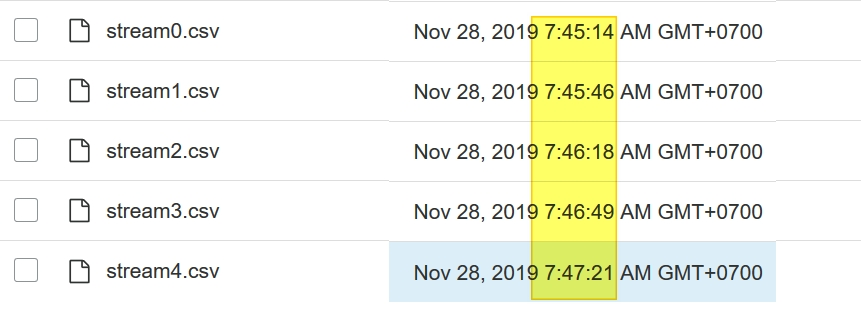

In [198]:
stream0 = spark.read.csv("s3://anson123/creditcard-streaming/stream0.csv",header = 'True',inferSchema='True')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
stream = {}
lrprediction_stream = {}
lr_accuracy = {}
lr_f1={}


for i in range(5):
    stream[i] = spark.read.csv("s3://anson123/creditcard-streaming/stream{}.csv".format(i),header = 'True',inferSchema='True')
    stream[i] = vectorizerFunction(stream[i],'class')

    lrprediction_stream[i] = lrModel.transform(stream[i])

    lr_accuracy[i] = accuracyevaluator.evaluate(lrprediction_stream[i])
    lr_f1[i] = f1evaluator.evaluate(lrprediction_stream[i]) 

    print("Test result of stream{} is".format(i))
    print("Accuracy of LogisticRegression is = %g"% (lr_accuracy[i]))
    print("F1 of LogisticRegression = %g \n" % (lr_f1[i]))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test result of stream0 is
Accuracy of LogisticRegression is = 0.9978
F1 of LogisticRegression = 0.998126 

Test result of stream1 is
Accuracy of LogisticRegression is = 0.9996
F1 of LogisticRegression = 0.999578 

Test result of stream2 is
Accuracy of LogisticRegression is = 0.9992
F1 of LogisticRegression = 0.9992 

Test result of stream3 is
Accuracy of LogisticRegression is = 0.999
F1 of LogisticRegression = 0.999029 

Test result of stream4 is
Accuracy of LogisticRegression is = 0.9988
F1 of LogisticRegression = 0.998846

In [52]:
lrprediction_stream[2].show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[67478.0,1.007833...|    0|[8.67523896400722...|[0.99982926701474...|       0.0|
|[67478.0,1.267602...|    0|[6.93116946998853...|[0.99902409552563...|       0.0|
|[67480.0,-1.07630...|    0|[7.98574887150973...|[0.99965983817278...|       0.0|
|[67482.0,-0.79236...|    0|[6.37341728977651...|[0.99829658829535...|       0.0|
|[67483.0,-1.22259...|    0|[8.22202776017821...|[0.99973140244960...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

In [53]:
#send the prediction result back to S3

for i in range(5):
    lrprediction_stream[i].select('prediction').coalesce(1).write.csv("s3://creditcard-smote/prediction{}.csv".format(i))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now We can see that the predictions are sent back to S3 for further processing, such as building reports or use BI tools to build dashboard, story ... etc. 

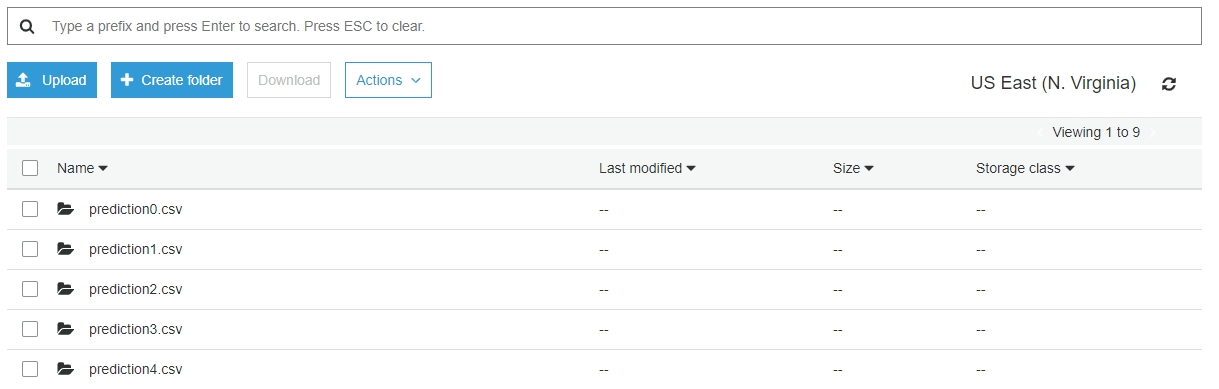

In [54]:
time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1574959640.3013499

In [55]:
time.time()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1574959645.9411888

In [33]:
from sklearn import neighbors

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
sc.install_pypi_package("imblearn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package("scikit-learn")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.0  
boto                       2.49.0 
imbalanced-learn           0.5.0  
imblearn                   0.0    
jmespath                   0.9.4  
joblib                     0.14.0 
lxml                       4.4.1  
mysqlclient                1.4.4  
nltk                       3.4.5  
nose                       1.3.4  
numpy                      1.14.5 
pandas                     0.25.1 
pip                        19.3.1 
py-dateutil                2.2    
python-dateutil            2.8.1  
python36-sagemaker-pyspark 1.2.4  
pytz                       2019.2 
PyYAML                     3.11   
scikit-learn               0.21.3 
scipy                      1.3.3  
setuptools                 42.0.1 
six                        1.12.0 
soupsieve                  1.9.3  
wheel                      0.33.6 
windmill                   1.6